## Data Exploration
#### Exploring high level trends within the dataset

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from textblob import TextBlob
from textblob import Word
import language_check
import enchant
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
import nltk
import xlrd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
%matplotlib inline

The data is downloaded from Kaggle for The Hewlett Foundation: Automatic Essay Scoring competition - https://www.kaggle.com/c/asap-aes.

Our goal is to understanding the underlying trends within the dataset to build better hypotheses. 

### Examine Dataset

In [2]:
xl_workbook = pd.ExcelFile('training_set_rel3.xlsx')
df = xl_workbook.parse("training_set")
df = df[df['domain1_score'] < 13]
df = df.dropna(axis = 1)

First, let us examine a data point:

In [3]:
essays = df['essay']
essays[11]

u"Dear @CAPS1 @CAPS2 I feel that computers do take away from peoples life and aren\u2019t as important than the other factors of life. First of all you know that the world is becoming obease because of lack of exercise. Also people don't realize that @CAPS3 warming is becomeing a big problum. Finally familys arn't as close as they used to be. these are all the reasons why computers arn't important to human socioty. First of the world is becomeing obease and cumputers play a huge part in this. Computers don't make people exercise they basicly just sit down on there couch and use the computer this won't help amarica get back into shape. Also computers become a habbit if a person uses a computer everyday of there life it will become an addiction then they won't be able to stop. Finally when people use the computer they don't realize the lack exersise there getting. This is the first reason why computeres are a bad thing. Next @CAPS3 warming is mealting the polar ice caps. Computers play a

Fortunately, there is not much cleaning that needs to be done. However, you'll notice that external references are replaced with an "@TEXT" formatted label. We don't foresee this causing any issues considering each essay generally contains around the same number of external references. We will however remove those key words when analyzing the number of spelling mistakes in each essay. The **character_filter** function below accomplishes this. 

In [4]:
#for spelling correction purporses, we will be removing any words with @ and % in them. 
def character_filter(words):
    punc = ["@","%"]
    for p in punc: 
        words = [word for word in words if p not in word]
        
    return words

### Analysis

Before analyzing the data, we must logically decide what features will impact the quality of an essay. We came up with six features:

1. Essay Length: How much content are they putting out?
2. Average Sentence Length: Are the sentences short and concise or long and convoluted?
3. Average Word Length: Are they using a sophisticated vocabulary?
4. Essay Sentiment: Does positivity or negativity affect the grade of an essay?
5. Grammar Mistakes: How often is the author making grammar mistakes?
6. Spelling Mistakes: How often is the author making spelling mistakes?

These six key features will allow us to gain some insight into what is happening in our data. to calculate this, the **TextBlob** package was used.

In [5]:
num_rows = df.shape[0]
essays = df['essay'].values

#initialize dataframe columns
df['essay length'] = np.nan 
df['sentence length'] = np.nan
df['average word length'] = np.nan 
df['sentiment'] = np.nan 
df['spelling'] = np.nan
df['grammar'] = np.nan

#check computation time
start = time.time()

#loop through each essay
for i in range(num_rows):  
    
    blob = TextBlob(essays[i])
    
    #number of words
    df.set_value(i,'essay length',len(blob.words))
    
    #sentence length
    sentence_len = [len(sentence.split(' ')) for sentence in blob.sentences]
    df.set_value(i,'sentence length', sum(sentence_len) / len(sentence_len))
    
    #essay sentiment
    df.set_value(i,'sentiment',blob.sentiment.polarity)
    
    #average word length
    word_len = [len(word) for word in blob.words]
    df.set_value(i,'average word length',sum(word_len) / len(word_len))
    
    #number of grammar mistakes
    tool = language_check.LanguageTool('en-US')
    matches = tool.check(essays[i])
    df.set_value(i,'grammar',len(matches))
    
    #spelling mistakes
    #this exception is made to catch any spelling errors cause by \u2019 apostraphies
    try:
        d = enchant.Dict('en_US')
        words = character_filter(blob.words)
        checks = [d.check(word) for word in words]
        df.set_value(i,'spelling', checks.count(False))    
    except Exception:
        pass

In [6]:
df = df.drop('rater1_domain1',1)
df = df.drop('rater2_domain1',1)

In [7]:
df.head()

,essay_id,essay_set,essay,domain1_score,essay length,sentence length,average word length,sentiment,spelling,grammar
0,1.0,1.0,"Dear local newspaper, I think effects computer...",8.0,343.0,21.0,4.0,0.310471,28.0,12.0
1,2.0,1.0,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,422.0,20.0,4.0,0.274000,31.0,15.0
2,3.0,1.0,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,283.0,19.0,4.0,0.340393,12.0,7.0
3,4.0,1.0,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,527.0,19.0,4.0,0.266828,77.0,36.0
4,5.0,1.0,"Dear @LOCATION1, I know having computers has a...",8.0,470.0,15.0,4.0,0.199684,29.0,17.0


### Visualization

The plots below will allow you to view the underlying trends within the data. The plots below visualize how the 6 features above impact the grade of an essay.

In [8]:
def plots(x,y,xlabel,title,ax,color='b'):
    
    ax.scatter(x,y,color = color)
    ax.set_ylabel('Grade')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    

In [9]:
import matplotlib.cm as cm
color=cm.rainbow(np.linspace(0,1,8))

def essayplot(essay, color):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))

    plots(df[df['essay_set'] == essay]['essay length'],df[df['essay_set'] == essay]['domain1_score'],'Essay Length', "Set "+str(essay)+": Essay Length vs. Essay Grade", ax1,color)
    plots(df[df['essay_set'] == essay]['sentence length'],df[df['essay_set'] == essay]['domain1_score'],'Average Sentence Length', "Set "+str(essay)+": Average Sentence Length vs. Essay Grade", ax2,color)
    plots(df[df['essay_set'] == essay]['average word length'],df[df['essay_set'] == essay]['domain1_score'],'Average Word Length', "Set "+str(essay)+": Average Word Length vs. Essay Grade",ax3,color)
    plots(df[df['essay_set'] == essay]['sentiment'],df[df['essay_set'] == essay]['domain1_score'],'Essay Sentiment', "Set "+str(essay)+": Essay Sentiment vs. Essay Grade",ax4,color)
    plots(df[df['essay_set'] == essay]['grammar'],df[df['essay_set'] == essay]['domain1_score'],'No. of Incorrect Grammar Instances', "Set "+str(essay)+": Grammar Mistakes vs. Essay Grade",ax5,color)
    plots(df[df['essay_set'] == essay]['spelling'],df[df['essay_set'] == essay]['domain1_score'],'No. of Spelling Mistakes', "Set "+str(essay)+": Spelling Mistakes vs. Essay Grade",ax6,color)
    
    fig.savefig('Essay1Features.png', bbox_inches = "tight")

### Essay Set 1

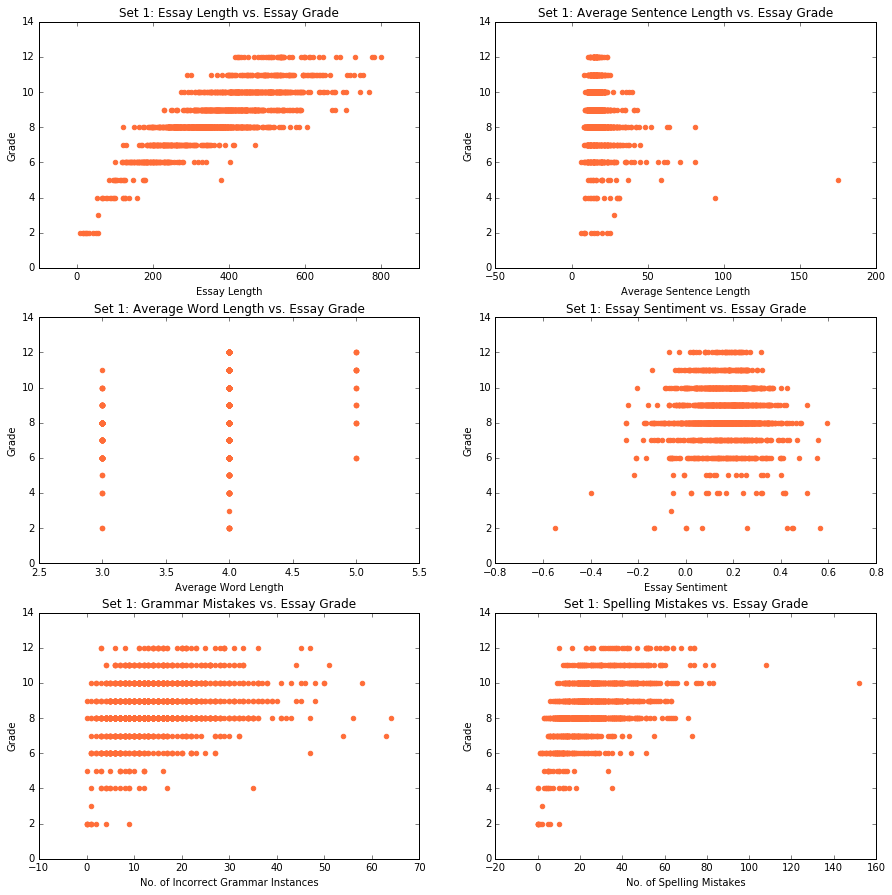

In [10]:
essayplot(1, color[6])

### Essay Set 2

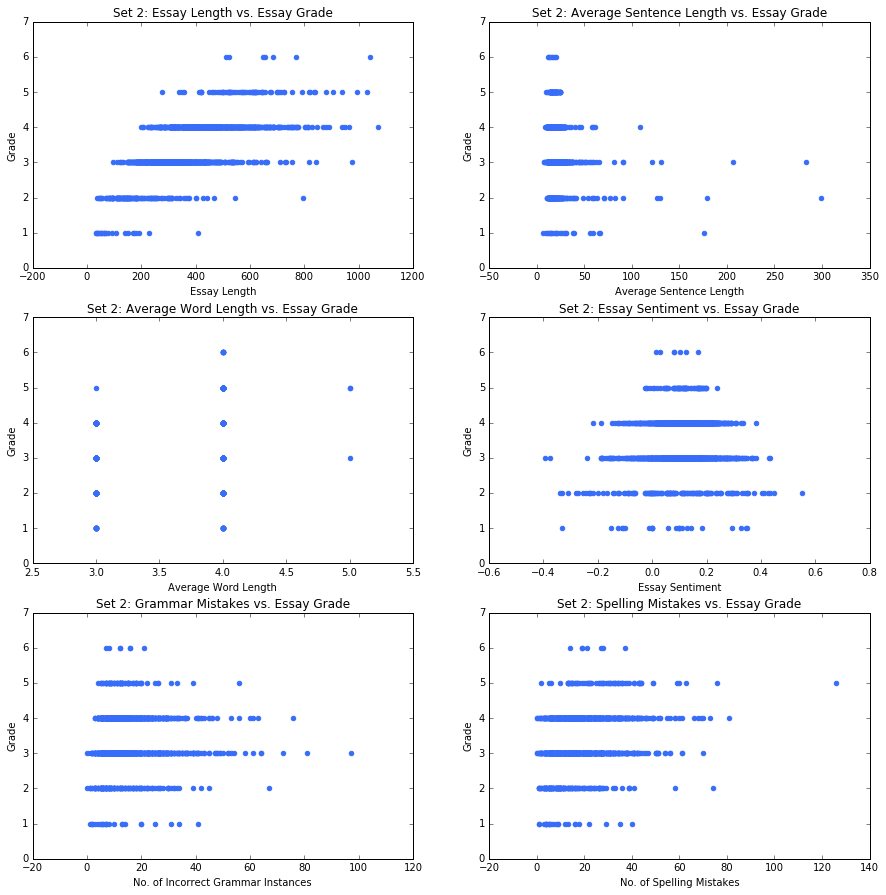

In [11]:
essayplot(2, color[1])

### Essay Set 3

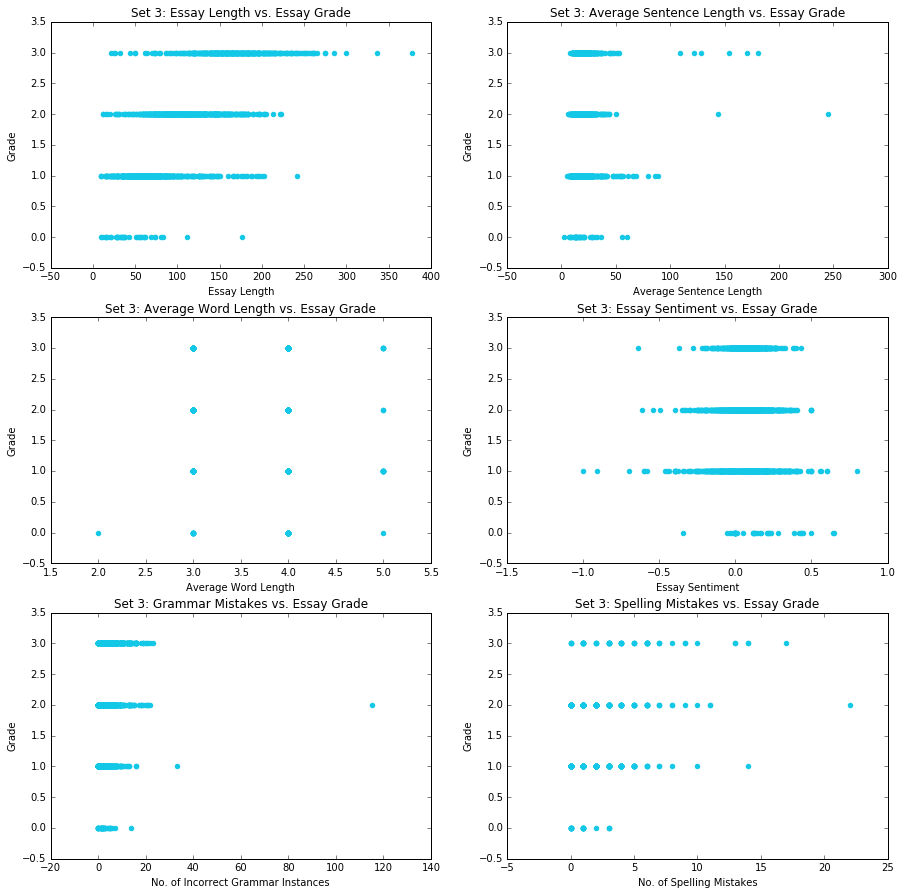

In [12]:
essayplot(3, color[2])

### Essay Set 4

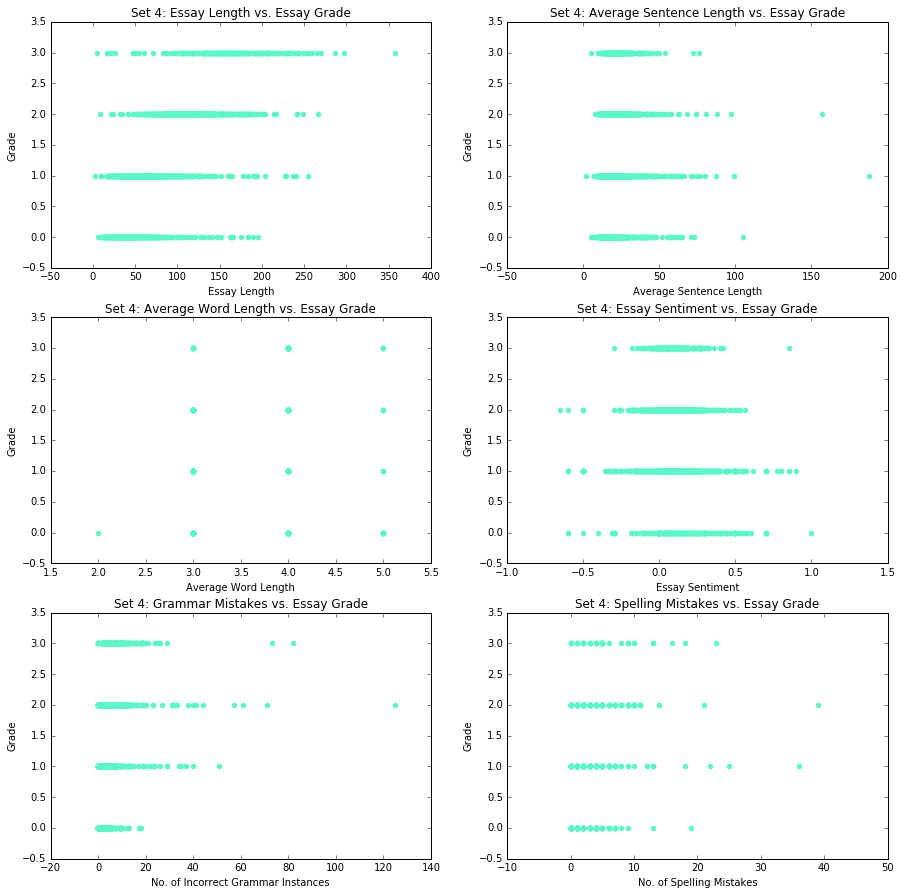

In [13]:
essayplot(4, color[3])

### Essay Set 5

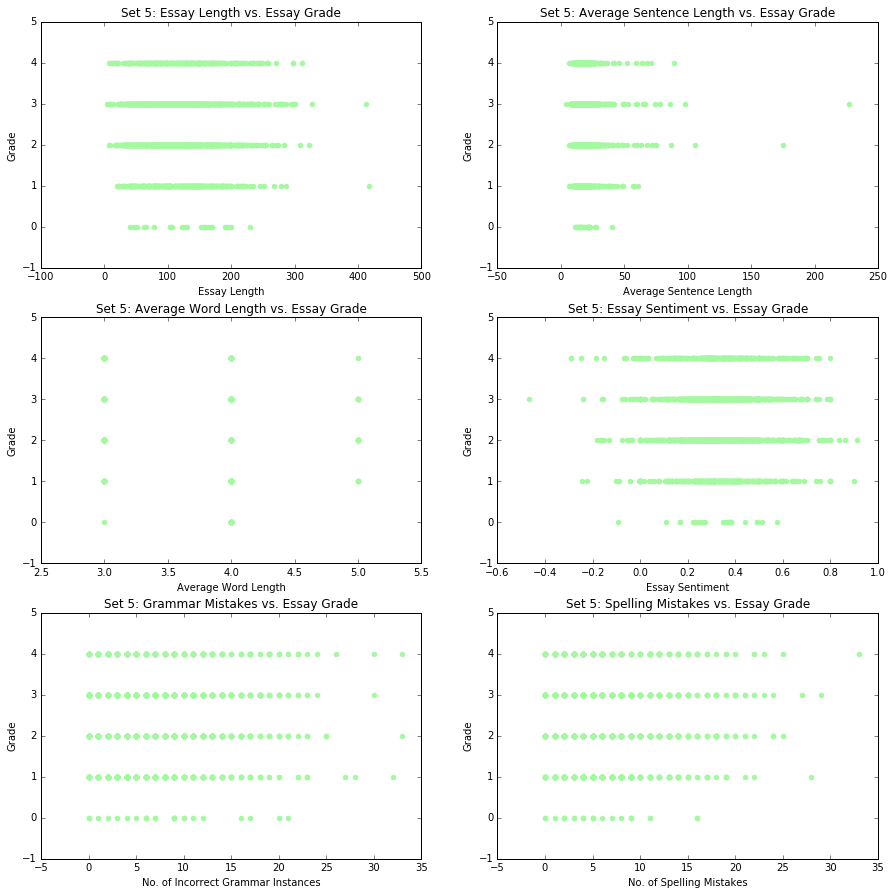

In [14]:
essayplot(5, color[4])

### Essay Set 6

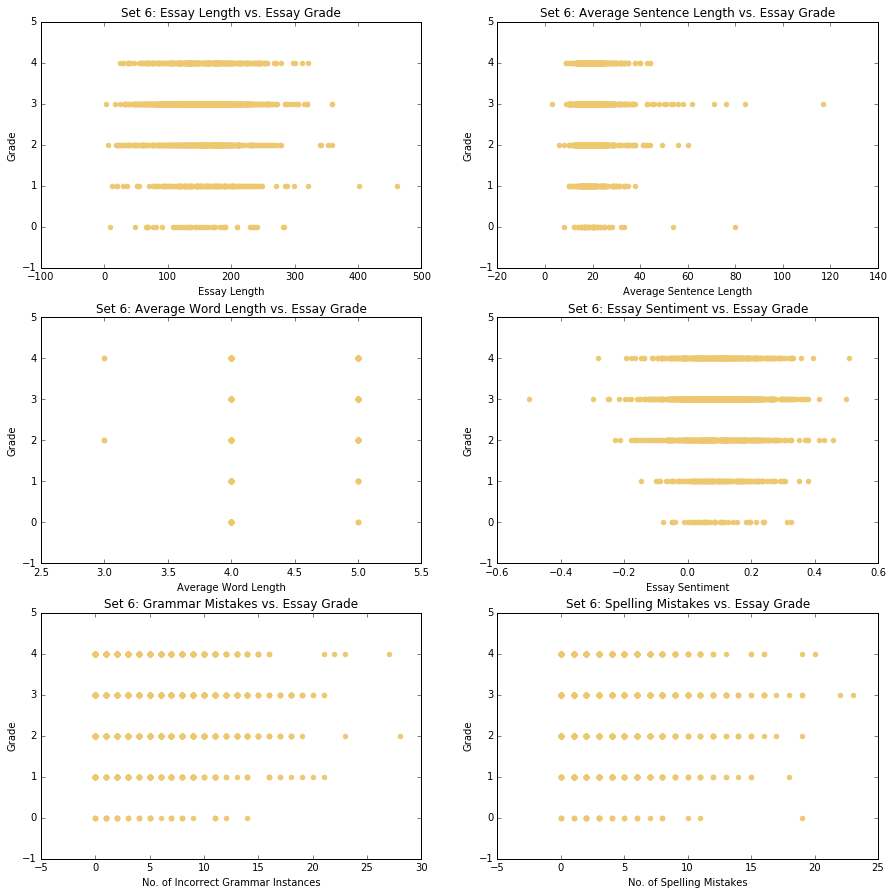

In [15]:
essayplot(6, color[5])

### Essay Set 7

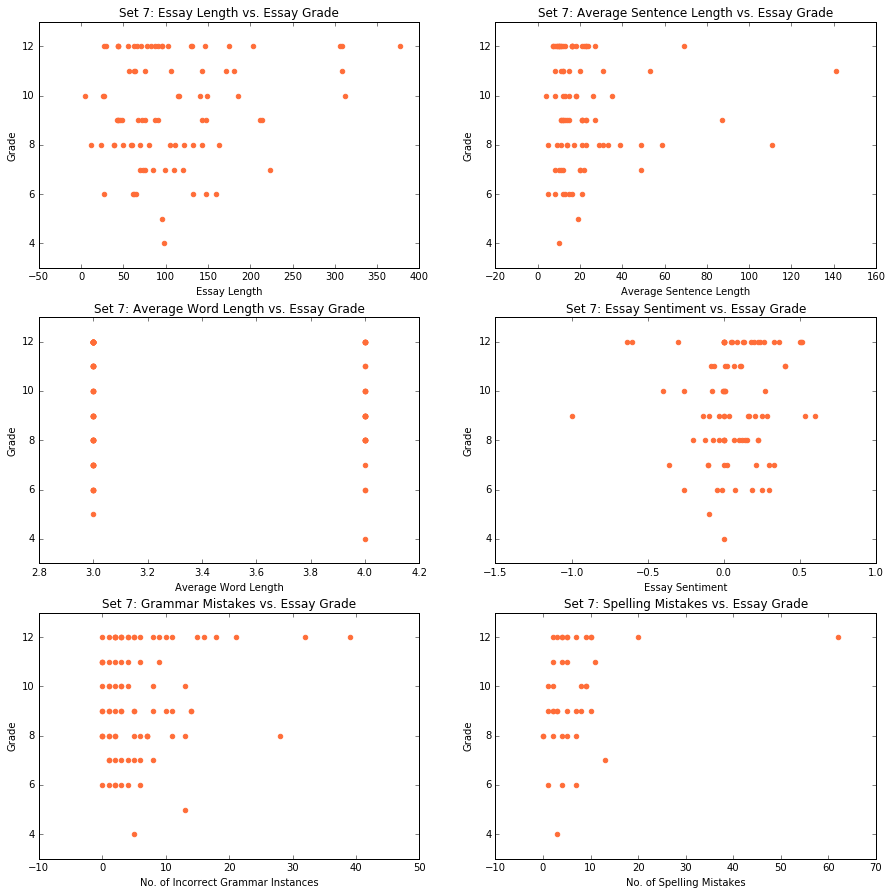

In [16]:
essayplot(7, color[6])

As expected, we were able to see general trends between the sentence structure of an essay and the grade it received. What was unexpected was the fact that the faults of an essay did not carry much weight. Noteably, we see that it is not uncommon to see essays with a large number of spelling mistakes receive a high grade. One could make the assumption that techonology's (Word's Spell Check) influence on writing has made it less imperitive for students to spell correctly. It seems as though the message carries more weight than specific errors in the essay.